# Dog Breed Image Classifier - Fast.AI Chapter Two Example Practice

In [1]:
#set things up
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

## setup API

In [2]:
#connect to an API service that will allow us to pull photos
bing_api_key = '8efadfd77fbb499095bd5ab68a5b28b6'
key = os.environ.get('AZURE_SEARCH_KEY', bing_api_key)

results = search_images_bing(key, 'daschund') #test
ims = results.attrgot('contentUrl')
len(ims) # verify we pulled the default 150 images

150

In [3]:
dest = 'images/testforchaptertwoohlook.jpg' 
download_url(ims[0], dest) # make sure the API is working by outputting an image

Path('images/testforchaptertwoohlook.jpg')

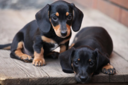

In [4]:
# VERY IMPORTANT look at doggo step
im = Image.open(dest)
im.to_thumb(128,128)

## start mass image pulling from API and begin verification

In [5]:
dog_breeds = 'daschund','corgi','poodle'
path = Path('dog_breeds_test')

In [9]:
# for each search term we want to work with, create its own folder and download images into it
if not path.exists():
    path.mkdir()
    for o in dog_breeds:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
# verify that photos were created
fns = get_image_files(path)
fns 

(#427) [Path('dog_breeds_test/corgi/00000000.jpg'),Path('dog_breeds_test/corgi/00000001.JPG'),Path('dog_breeds_test/corgi/00000002.jpg'),Path('dog_breeds_test/corgi/00000004.jpg'),Path('dog_breeds_test/corgi/00000005.jpg'),Path('dog_breeds_test/corgi/00000006.jpg'),Path('dog_breeds_test/corgi/00000008.jpeg'),Path('dog_breeds_test/corgi/00000009.jpg'),Path('dog_breeds_test/corgi/00000010.jpg'),Path('dog_breeds_test/corgi/00000011.jpg')...]

In [11]:
# allegedly sometimes this fails, bad file types or something, good to check before we move on
failed = verify_images(fns)
failed

(#0) []

In [12]:
#need be, get rid of the bad photos
failed.map(Path.unlink);

## start creation of DataLoader(s) for model

In [13]:
doggos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #independent and dependent variable defining
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # hold back 20% for verification, set seed for consistency when working with this
    get_y=parent_label, # parent_label I believe is just the containing folder's name
    item_tfms=Resize(128))

In [17]:
??ImageBlock

In [18]:
dls = doggos.dataloaders(path) #create the Loaders

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


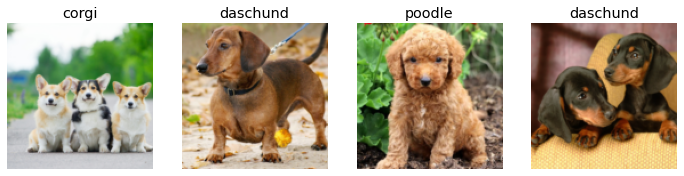

In [19]:
dls.valid.show_batch(max_n=4, nrows=1) #make sure it's working

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


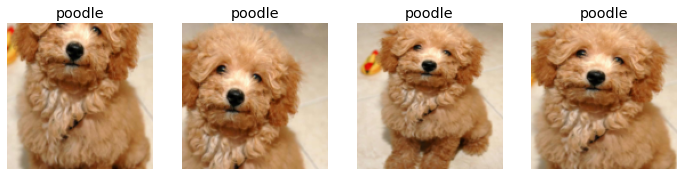

In [21]:
# # input randomly cropped versions of each image per epoch
#doggos = doggos.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
#dls = doggos.dataloaders(path)
#dls.train.show_batch(max_n=4, nrows=1, unique=True)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


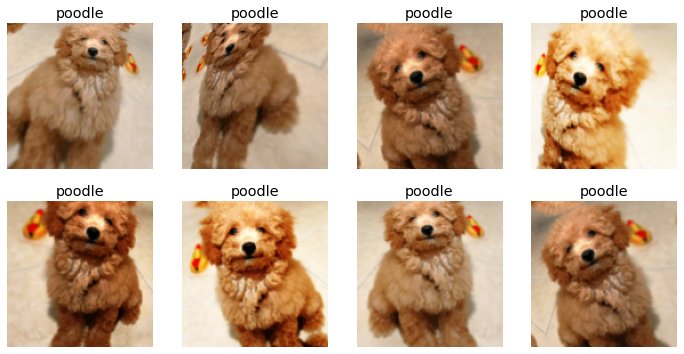

In [22]:
# # input randomly "augmented" versions of each image per epoch
#doggos = doggos.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
#dls = doggos.dataloaders(path)
#dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [24]:
#okay geez so this is what they finally go with in the end, a combination it seems
doggos = doggos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = doggos.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


## training the model

In [26]:
#dls.train.show_batch(max_n=8, nrows=2, unique=True) #if we wanna triple check the latest input

In [27]:
#create the learner
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.273740,0.012545,0.000000,01:22


epoch,train_loss,valid_loss,error_rate,time
0,0.085099,0.004137,0.000000,01:57
1,0.056824,0.000517,0.000000,02:07
2,0.039297,0.000192,0.000000,02:11
3,0.030398,0.000166,0.000000,01:56


## validating aspects of the trained model

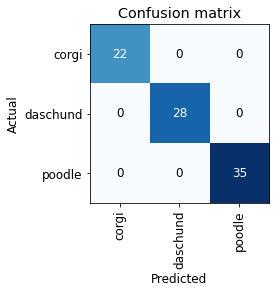

In [28]:
#this will show us if any errors exist in the model with classifying
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

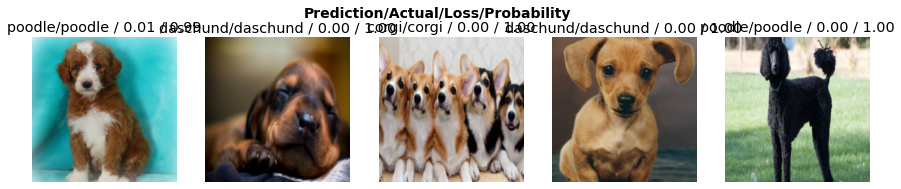

In [29]:
# let's check out what images were the hardest for the model to figure out
interp.plot_top_losses(5, nrows=1)

In [30]:
# let's see if we need to clean any of our data
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
# if needed, use the above tool and then run this cell to unlink any unwanted images
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## export the model and prepare for web deployment

In [33]:
learn.export()

In [ ]:
# go look at the Deployment notebook